In [1]:
# Importing the required modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
import pickle
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [3]:
pip install catboost

     |████████████████████████████████| 76.3 MB 1.5 MB/s 


In [4]:
# Importing the dataset
df = pd.read_csv('Cleaned_Soil.csv')

In [5]:
# Obtaining data specific to Anantapur

In [6]:
df = df[df['District'] == 'Guntur']
df.head()

,Unnamed: 0,Latitude,Longitude,District,Mandal,Village,SoilType,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI,ARVI,EVI,GCI,NDWI,Crop
655,655,16.24,80.79,Guntur,Kollur,Chilumuru,Black soil,8.27,0.49,0.60,17.1,304.0,5734.0,634.0,21.65,1.62,1.36,4.53,2.80,6.07,0.649583,0.437051,1.199912,3.856140,-0.658478,Turmeric
656,656,16.40,81.31,Guntur,Kollur,Chilumuru,Black soil,8.05,0.68,0.78,38.6,535.0,5400.0,1077.0,95.09,1.56,2.23,29.90,6.52,7.34,0.141404,0.060657,2.256494,-0.328947,0.196850,Turmeric
657,657,16.24,80.79,Guntur,Kollur,Chilumuru,Black soil,7.77,1.13,0.54,8.3,129.0,6984.0,1565.0,199.10,0.62,1.23,16.59,5.65,6.24,0.649583,0.437051,1.199912,3.856140,-0.658478,Turmeric
658,658,16.24,80.79,Guntur,Kollur,Chilumuru,Black soil,8.15,0.31,0.39,5.9,165.0,6089.0,941.0,18.89,0.54,0.99,4.19,2.52,5.10,0.649583,0.437051,1.199912,3.856140,-0.658478,Yam
659,659,16.24,80.79,Guntur,Kollur,Chilumuru,Black soil,8.10,0.32,0.42,4.7,135.0,5812.0,932.0,17.21,0.68,1.13,3.80,2.96,6.53,0.649583,0.437051,1.199912,3.856140,-0.658478,Yam


In [7]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'District', 'Mandal', 'Village', 'ARVI', 'EVI', 'GCI', 'NDWI'], axis = 1)
df.describe()

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI
count,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000
mean,8.072559,0.737971,0.539353,22.956088,247.779412,6215.823529,1033.347059,62.026000,1.414412,1.462941,10.493588,3.306147,10.563088,0.521935
std,0.317204,0.833152,0.161586,16.451900,138.177395,1623.475786,523.213186,99.480417,1.530636,0.650554,11.583131,2.509120,6.839351,0.283118
min,6.830000,0.130000,0.180000,1.800000,66.000000,970.000000,111.000000,5.800000,0.120000,0.470000,1.300000,0.810000,2.180000,-0.987952
25%,7.940000,0.317500,0.437500,11.275000,165.750000,5135.250000,649.750000,18.662500,0.620000,1.020000,4.002500,1.567500,5.655000,0.291074
50%,8.125000,0.470000,0.530000,18.900000,216.000000,6364.000000,927.500000,32.050000,0.975000,1.290000,5.820000,2.320000,8.050000,0.521123
75%,8.262500,0.830000,0.630000,30.700000,286.000000,7381.000000,1378.500000,66.065000,1.642500,1.690000,11.235000,3.680000,13.520000,0.746100
max,9.320000,7.850000,1.230000,140.600000,1553.000000,13304.000000,2476.000000,990.090000,19.200000,5.020000,94.800000,12.350000,43.740000,0.893920


In [8]:
# Analysis of SoilType

In [9]:
df.SoilType.unique()

array(['Black soil'], dtype=object)

In [10]:
df['SoilType'] = df['SoilType'].replace('Black soil', 'Black Soil')
df.SoilType.unique()

array(['Black Soil'], dtype=object)

In [11]:
soilCount = dict(df['SoilType'].value_counts())
soilCount

{'Black Soil': 340}

<BarContainer object of 1 artists>

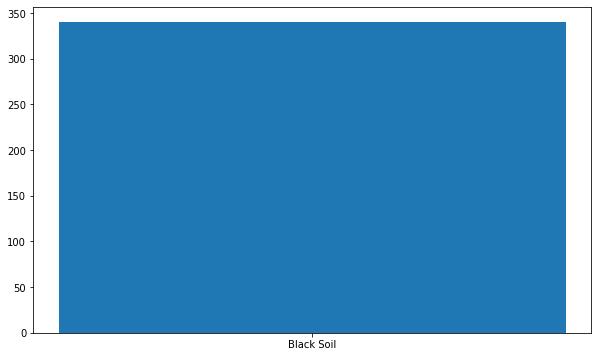

In [12]:
soilType = soilCount.keys()
soilCounts = soilCount.values()
plt.bar(soilType, soilCounts)

In [13]:
# Analysis of Crops grown 

In [14]:
df.Crop.unique()

array(['Turmeric', 'Yam', 'Paddy', 'Banana', 'yam', 'Cotton',
       'Ridge Guard', 'Chilli', 'Vegetables'], dtype=object)

In [15]:
df['Crop'].value_counts()

Chilli         98
Paddy          85
Cotton         80
Turmeric       36
Yam            24
Banana         14
yam             1
Vegetables      1
Ridge Guard     1
Name: Crop, dtype: int64

Paddy + Cotton    165
Chilli             98
Turmeric           36
Yam                25
Banana             14
Name: Crop, dtype: int64


<BarContainer object of 5 artists>

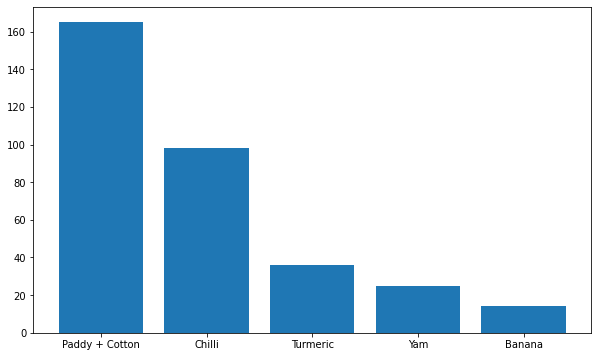

In [16]:
df['Crop'] = df['Crop'].replace('yam', 'Yam')
df['Crop'] = df['Crop'].replace(['Paddy', 'Cotton'], 'Paddy + Cotton')
df = df[(df['Crop'] != 'Vegetables') & (df['Crop'] != 'Ridge Guard')]

print(df['Crop'].value_counts())
cropCount = dict(df['Crop'].value_counts())
cropType = cropCount.keys()
cropCounts = cropCount.values()
plt.bar(cropType, cropCounts)

In [17]:
# Getting rid of features that have a high correlation among one another

In [18]:
cor_matrix = df.corr()
cor_matrix

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI
pH,1.000000,-0.401141,-0.299367,-0.403982,-0.037303,-0.264846,-0.370749,-0.274872,-0.139346,-0.244247,-0.573187,-0.611952,-0.546563,0.167316
EC,-0.401141,1.000000,0.243990,0.196558,0.173598,0.185146,0.240402,0.828407,0.089097,0.441005,0.150949,0.336557,0.336473,-0.036728
OC,-0.299367,0.243990,1.000000,0.618067,0.497872,-0.023821,0.110199,0.205578,0.396956,0.272625,0.102547,0.275944,0.374257,0.014704
P,-0.403982,0.196558,0.618067,1.000000,0.483960,-0.157398,0.142226,0.082094,0.479919,0.222239,0.221820,0.313875,0.426199,-0.023365
K,-0.037303,0.173598,0.497872,0.483960,1.000000,-0.150087,-0.023388,0.078110,0.416968,0.161344,-0.175868,-0.020528,0.276539,-0.011496
Ca,-0.264846,0.185146,-0.023821,-0.157398,-0.150087,1.000000,0.078633,0.094773,-0.098378,0.076135,0.020379,0.054914,0.028215,0.125753
Mg,-0.370749,0.240402,0.110199,0.142226,-0.023388,0.078633,1.000000,0.342552,0.151412,0.529289,0.653097,0.740648,0.364612,-0.374706
S,-0.274872,0.828407,0.205578,0.082094,0.078110,0.094773,0.342552,1.000000,0.074904,0.559119,0.223515,0.374149,0.200183,-0.081657
Zn,-0.139346,0.089097,0.396956,0.479919,0.416968,-0.098378,0.151412,0.074904,1.000000,0.203424,0.022695,0.229737,0.227489,-0.094296
B,-0.244247,0.441005,0.272625,0.222239,0.161344,0.076135,0.529289,0.559119,0.203424,1.000000,0.424479,0.534559,0.359413,-0.145808


In [19]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
print('Columns to be dropped : ', to_drop)
df = df.drop(to_drop, axis = 1)
print('Columns taken into consideration : ', list(df.columns))

Columns to be dropped :  ['P', 'S', 'B', 'Fe', 'Cu', 'Mn']
Columns taken into consideration :  ['SoilType', 'pH', 'EC', 'OC', 'K', 'Ca', 'Mg', 'Zn', 'NDVI', 'Crop']


In [20]:
# Separating the dependent and independent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [21]:
# Encoding SoilType as it is a categorical variable
X = pd.get_dummies(X, prefix='', prefix_sep='')
print(X.head(1))
print(y.head(1))
X = X.values
y = y.values

       pH    EC   OC      K      Ca     Mg    Zn      NDVI  Black Soil
655  8.27  0.49  0.6  304.0  5734.0  634.0  1.62  0.649583           1
655    Turmeric
Name: Crop, dtype: object


In [22]:
# Standardizing the independent variables using Feature Scaling
sc = StandardScaler()
X[:, 0:8] = sc.fit_transform(X[:, 0:8])

In [23]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# SMOTE: Synthetic Minority Over-sampling Technique

In [24]:
# Separating the dependent and independent variables
df = df.drop(['SoilType'], axis=1)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
smote = SMOTE()
X, y = smote.fit_resample(X, y)

In [25]:
# Standardizing the independent variables using Feature Scaling
sc2 = StandardScaler()
X[:, :] = sc2.fit_transform(X[:, :])

In [26]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# K-Nearest Neighbors Classifier

In [27]:
clf1 = KNeighborsClassifier(weights='distance')
clf1.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [28]:
y_test_pred = clf1.predict(X_test)
y_train_pred = clf1.predict(X_train)
AC1_train = accuracy_score(y_train, y_train_pred)
AC1_test = accuracy_score(y_test, y_test_pred)

In [29]:
print('Training Accuracy: ', AC1_train)
print('Testing Accuracy: ', AC1_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7632850241545893


In [30]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf1, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 76.55 %
Standard Deviation: 5.27 %


# Decision Tree Classifier

In [31]:
clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [32]:
y_test_pred = clf2.predict(X_test)
y_train_pred = clf2.predict(X_train)
AC2_train = accuracy_score(y_train, y_train_pred)
AC2_test = accuracy_score(y_test, y_test_pred)

In [33]:
print('Training Accuracy: ', AC2_train)
print('Testing Accuracy: ', AC2_test)

Training Accuracy:  1.0
Testing Accuracy:  0.6473429951690821


In [34]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf2, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 66.35 %
Standard Deviation: 6.47 %


# Random Forest Classifier

In [35]:
clf3_3 = RandomForestClassifier(random_state=0)
clf3_3.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [36]:
y_test_pred = clf3_3.predict(X_test)
y_train_pred = clf3_3.predict(X_train)
AC3_train = accuracy_score(y_train, y_train_pred)
AC3_test = accuracy_score(y_test, y_test_pred)

In [37]:
print('Training Accuracy: ', AC3_train)
print('Testing Accuracy: ', AC3_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7536231884057971


In [38]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf3_3, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 78.15 %
Standard Deviation: 5.09 %


In [39]:
pickle.dump(clf3_3, open('Guntur_model.pkl', 'wb'))
pickle.dump(sc2, open('Guntur_scaler.pkl', 'wb'))

# XGBoost

In [40]:
clf4_4 = HistGradientBoostingClassifier(random_state=0)
clf4_4.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=0)

In [41]:
y_test_pred = clf4_4.predict(X_test)
y_train_pred = clf4_4.predict(X_train)
AC4_train = accuracy_score(y_train, y_train_pred)
AC4_test = accuracy_score(y_test, y_test_pred)

In [42]:
print('Training Accuracy: ', AC4_train)
print('Testing Accuracy: ', AC4_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7536231884057971


In [43]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf4_4, X = X_train, y = y_train, cv = 10)

In [44]:
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 76.55 %
Standard Deviation: 5.22 %


In [45]:
# pickle.dump(clf4_4, open('Guntur_model.pkl', 'wb'))
# pickle.dump(sc2, open('Guntur_scaler.pkl', 'wb'))

# Multi-layer Perceptron Classifier

In [46]:
clf5 = MLPClassifier(random_state=0, learning_rate= 'adaptive')
clf5.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', random_state=0)

In [47]:
y_test_pred = clf5.predict(X_test)
y_train_pred = clf5.predict(X_train)
AC5_train = accuracy_score(y_train, y_train_pred)
AC5_test = accuracy_score(y_test, y_test_pred)

In [48]:
print('Training Accuracy: ', AC5_train)
print('Testing Accuracy: ', AC5_test)

Training Accuracy:  0.7556634304207119
Testing Accuracy:  0.6135265700483091


In [49]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf5, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 68.13 %
Standard Deviation: 6.54 %


# Catboost

In [50]:
from catboost import CatBoostClassifier, Pool, cv

model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

model.calc_feature_statistics(X_train, y_train, feature=1, plot=True)

train_data = Pool(data=X_train, label=y_train)
model.get_feature_importance(train_data)

#Cross-Validation
cv_dataset = Pool(data=X_train, label=y_train)
params = {"iterations": 100, "depth": 2, "loss_function": "MultiClass", "verbose": False}
scores = cv(cv_dataset, params, fold_count=5, plot="True")

model = CatBoostClassifier(loss_function='MultiClass')
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

model.score(X_test, y_test)

# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

0:	learn: 1.4710752	total: 47.3ms	remaining: 4.68s
1:	learn: 1.2416028	total: 49.4ms	remaining: 2.42s
2:	learn: 1.1718143	total: 50.7ms	remaining: 1.64s
3:	learn: 1.1147958	total: 52.1ms	remaining: 1.25s
4:	learn: 1.0938666	total: 53.3ms	remaining: 1.01s
5:	learn: 1.0787106	total: 54.7ms	remaining: 858ms
6:	learn: 1.0535223	total: 56.1ms	remaining: 745ms
7:	learn: 1.0277621	total: 57.2ms	remaining: 657ms
8:	learn: 1.0103749	total: 58.3ms	remaining: 590ms
9:	learn: 0.9591727	total: 59.5ms	remaining: 535ms
10:	learn: 0.9222272	total: 60.7ms	remaining: 491ms
11:	learn: 0.8992733	total: 62ms	remaining: 454ms
12:	learn: 0.8777231	total: 63.2ms	remaining: 423ms
13:	learn: 0.8455347	total: 64.5ms	remaining: 396ms
14:	learn: 0.8291569	total: 66ms	remaining: 374ms
15:	learn: 0.8051518	total: 67.3ms	remaining: 353ms
16:	learn: 0.7912180	total: 68.6ms	remaining: 335ms
17:	learn: 0.7672014	total: 70ms	remaining: 319ms
18:	learn: 0.7404950	total: 71.4ms	remaining: 304ms
19:	learn: 0.7252276	total: 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1.221083601
bestIteration = 99

Training on fold [1/5]

bestTest = 1.190705253
bestIteration = 99

Training on fold [2/5]

bestTest = 1.195486691
bestIteration = 99

Training on fold [3/5]

bestTest = 1.214558714
bestIteration = 99

Training on fold [4/5]

bestTest = 1.20352006
bestIteration = 99



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
2:	learn: 1.4563849	total: 320ms	remaining: 1m 46s
3:	learn: 1.4089109	total: 437ms	remaining: 1m 48s
4:	learn: 1.3612097	total: 548ms	remaining: 1m 49s
5:	learn: 1.3157660	total: 657ms	remaining: 1m 48s
6:	learn: 1.2737633	total: 774ms	remaining: 1m 49s
7:	learn: 1.2344288	total: 879ms	remaining: 1m 48s
8:	learn: 1.2008442	total: 990ms	remaining: 1m 48s
9:	learn: 1.1688604	total: 1.09s	remaining: 1m 48s
10:	learn: 1.1387427	total: 1.21s	remaining: 1m 49s
11:	learn: 1.1021587	total: 1.32s	remaining: 1m 48s
12:	learn: 1.0701753	total: 1.44s	remaining: 1m 49s
13:	learn: 1.0406212	total: 1.55s	remaining: 1m 49s
14:	learn: 1.0117166	total: 1.68s	remaining: 1m 50s
15:	learn: 0.9888771	total: 1.78s	remaining: 1m 49s
16:	learn: 0.9621370	total: 1.89s	remaining: 1m 49s
17:	learn: 0.9375343	total: 1.99s	remaining: 1m 48s
18:	learn: 0.9123609	total: 2.1s	remaining: 1m 48s
19:	learn: 0.8888226	total: 2.21s	remaining: 1m 48s
20:	learn: 0.8673893	t